In [1]:
import pandas as pd
import numpy as np
from cherenkovdeconvolution import util

#p.set_printoptions(threshold=np.inf)
#df = pd.read_csv('sample.csv')
df=pd.read_csv('sample.csv', nrows=1000000)
#print(df.head(8))
#X = df[['SplineMPEDirectHitsD.dir_track_length',
#'SPEFit2_HVFitParams.nmini'                       ,
#'LineFitGeoSplit2.zenith',
#   'SplineMPE.zenith'    ,
#     'SplineMPE.azimuth' 
#       'SPEFit2GeoSplit1BayesianFitParams.nmini',
#       'SPEFit2Bayesian.x',
#       'VariousVariables.Cone_Angle',
#       'SPEFit2TimeSplit1FitParams.logl',
#       'weight_honda_h4a']]
X = df[['SPEFit2Bayesian.x',
        'SPEFit2BayesianFitParams.nmini',
        'SPEFit2_HVFitParams.nmini',
        'SplineMPE.zenith',
        'SplineMPECharacteristicsIC.avg_dom_dist_q_tot_dom',
        'SplineMPEDirectHitsD.dir_track_length',
        'SplineMPEDirectHitsICB.n_early_strings',
        'SplineMPEDirectHitsICB.n_late_doms',
        'SplineMPEDirectHitsICD.n_dir_strings',
        'SplineMPEDirectHitsICE.n_late_strings',
        'SplineMPETruncatedEnergy_SPICEMie_AllDOMS_MuEres.value']]

Y = df['MCPrimary.energy']
#'Dustyness.n_doms_in_dust','BestTrackDirectHitsICC.n_early_strings',
binning_E = np.logspace(np.log10(Y.min()-10),
np.log10(Y.max()+100), 13)    # creating 12 bins for the energy 



#Binning overflow & underflow manually
overflow = 1e10
bins_over = np.append(binning_E,overflow)
binning_E = bins_over

Y = np.digitize(Y, binning_E)  

Y = Y - 1

n_test = int(len(df)/10)

X_train = X.iloc[n_test:]#splitting the dataframe
Y_train = Y[n_test:]

X_test = X.iloc[:n_test]
Y_test = Y[:n_test]

f_true = util.fit_pdf(Y_test) 
f_true



array([2.5758e-01, 3.6933e-01, 2.1760e-01, 9.6360e-02, 3.7990e-02,
       1.3770e-02, 4.6200e-03, 1.8000e-03, 6.3000e-04, 2.4000e-04,
       5.0000e-05, 3.0000e-05])

In [2]:
from cherenkovdeconvolution import dsea
from sklearn.naive_bayes import GaussianNB
#from sklearn.naive_bayes import BernoulliNB #worse than gaussian
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.tree import ExtraTreeClassifier # works extremly good on the data
#from sklearn.ensemble import RandomForestClassifier# super slow; about the same results as ExtraTree

f_est = dsea(X_test, X_train, Y_train, GaussianNB(), K=3) 

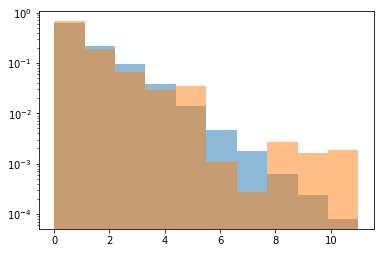

In [3]:
from matplotlib import pyplot as plt
plt.hist(range(12), weights = f_true, alpha = 0.5)
plt.hist(range(12), weights = f_est, alpha = 0.5)
plt.yscale('log')
plt.show()

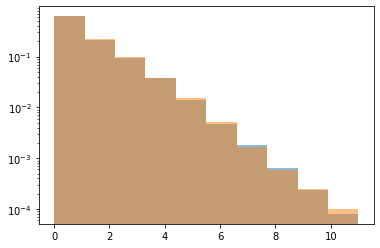

In [4]:
from cherenkovdeconvolution import dsea
from sklearn.tree import ExtraTreeClassifier

f_est2 = dsea(X_test, X_train, Y_train, ExtraTreeClassifier(), K=3) 
plt.hist(range(12), weights = f_true, alpha = 0.5)
plt.hist(range(12), weights = f_est2, alpha = 0.5)
plt.yscale('log')
plt.show()

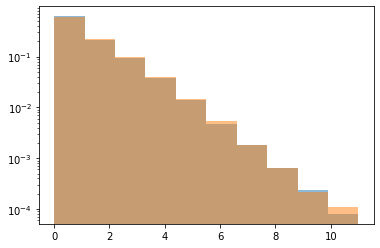

In [6]:
from cherenkovdeconvolution import dsea
from sklearn.ensemble import RandomForestClassifier
f_est3 = dsea(X_test, X_train, Y_train,RandomForestClassifier(), K=3) 
plt.hist(range(12), weights = f_true, alpha = 0.5)
plt.hist(range(12), weights = f_est3, alpha = 0.5)
plt.yscale('log')
plt.show()

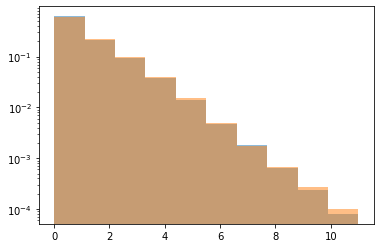

In [7]:
from cherenkovdeconvolution import dsea
from sklearn.tree import DecisionTreeClassifier
f_est4 = dsea(X_test, X_train, Y_train,DecisionTreeClassifier(), K=3) 
plt.hist(range(12), weights = f_true, alpha = 0.5)
plt.hist(range(12), weights = f_est4, alpha = 0.5)
plt.yscale('log')
plt.show()